# Subtraction of double counted impacts - Testing

This is for testing whether our approach to subtract impact is doing what we want.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import yaml
import brightway2 as bw
from premise.activity_maps import InventorySet, get_mapping
import wurst
from wurst import searching as ws
from premise.geomap import Geomap
import pickle

First load the dictionary of regionalized activities that we created:

In [2]:
all_act_keys = pickle.load(open("all_act_keys.pkl", "rb"))
all_act_keys

{'bioigcc': {'CAZ': ('ecoinvent_remind_default_2030',
   'b5878245699b41e2910b073031f4d3d6'),
  'CHA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'EUR': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'IND': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'JPN': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'LAM': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'MEA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'NEU': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'OAS': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'REF': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'SSA': ('ecoinvent_remind_default_2030', 'b5878245699b41e2910b073031f4d3d6'),
  'USA': ('ecoinvent_remind_default_2030',
   'b5878245699b41e2910b073031f4d3d6')},
 'geohdr': {'CAZ': ('e

In [7]:
all_activities = {}
for tech, ddict in all_act_keys.items():
    data = {}
    for reg, key in ddict.items():
        data[reg] = bw.get_activity(key)
    all_activities[tech] = data
all_activities

{'bioigcc': {'CAZ': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'CHA': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'EUR': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'IND': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'JPN': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'LAM': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'MEA': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'NEU': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'OAS': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'REF': 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
  'SSA': 'electricity production, at BIGCC power plant, no CCS' (kilo

Prepare brightway:

In [4]:
bw.projects.set_current("test")
eidb = bw.Database("ecoinvent_remind_default_2030")
len(eidb)

31544

## Now do the LCIA, subtracting impacts step by step

As a first test, we use a coal pc plant.

In [5]:
method_list = [
    "EF v3.0, acidification, accumulated exceedance (ae)",
    "EF v3.0, climate change, global warming potential (GWP100)",
    "EF v3.0, ecotoxicity: freshwater, comparative toxic unit for ecosystems (CTUe)",
    "EF v3.0, energy resources: non-renewable, abiotic depletion potential (ADP): fossil fuels",
    "EF v3.0, eutrophication: freshwater, fraction of nutrients reaching freshwater end compartment (P)",
    "EF v3.0, eutrophication: marine, fraction of nutrients reaching marine end compartment (N)",
    "EF v3.0, eutrophication: terrestrial, accumulated exceedance (AE)",
    "EF v3.0, human toxicity: carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, human toxicity: non-carcinogenic, comparative toxic unit for human (CTUh)",
    "EF v3.0, ionising radiation: human health, human exposure efficiency relative to u235",
    "EF v3.0, land use, soil quality index",
    "EF v3.0, material resources: metals/minerals, abiotic depletion potential (ADP): elements (ultimate reserves)",
    "EF v3.0, ozone depletion, ozone depletion potential (ODP)",
    "EF v3.0, particulate matter formation, impact on human health",
    "EF v3.0, photochemical ozone formation: human health, tropospheric ozone concentration increase",
    "EF v3.0, water use, user deprivation potential (deprivation-weighted water consumption)"
]

midpoints = [m.split(",")[1].strip() for m in method_list]
midpoints

['acidification',
 'climate change',
 'ecotoxicity: freshwater',
 'energy resources: non-renewable',
 'eutrophication: freshwater',
 'eutrophication: marine',
 'eutrophication: terrestrial',
 'human toxicity: carcinogenic',
 'human toxicity: non-carcinogenic',
 'ionising radiation: human health',
 'land use',
 'material resources: metals/minerals',
 'ozone depletion',
 'particulate matter formation',
 'photochemical ozone formation: human health',
 'water use']

In [6]:
methods = []
for mp in midpoints:
    for m in bw.methods:
        if m[0] == "EF v3.0" and mp == m[1]:
            methods.append(m)
methods

[('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
 ('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe) '),
 ('EF v3.0',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('EF v3.0',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('EF v3.0',
  'eutrophication: marine',
  'fraction of nutrients reaching marine end compartment (N)'),
 ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE) '),
 ('EF v3.0',
  'human toxicity: carcinogenic',
  'comparative toxic unit for human (CTUh) '),
 ('EF v3.0',
  'human toxicity: non-carcinogenic',
  'comparative toxic unit for human (CTUh) '),
 ('EF v3.0',
  'ionising radiation: human health',
  'human exposure efficiency relative to u235'),
 ('EF v3.0', 'land use', 'soil quality index'),
 ('EF v3.0',
  'material resources: 

In [10]:
to_subtract = []
for tech, ddict in all_activities.items():
    if tech != "pc":
        to_subtract += list(ddict.values())
to_subtract

['electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER, None),
 'electricity production, at BIGCC power plant, no CCS' (kilowatt hour, RER,

In [15]:
demand = {all_activities["pc"]["CHA"]: 1}
lca = bw.LCA(demand=demand)
lca.lci()

temp = []
for m in methods:
    lca.switch_method(m)
    lca.lcia()
    temp.append(lca.score)

impacts = [temp]

In [16]:
counter = 0
for act in to_subtract:
    i = lca.product_dict[act.key]
    j = lca.activity_dict[act.key]
    lca.technosphere_matrix[i,:] = 0
    lca.technosphere_matrix[:,j] = 0

    # redo lci
    lca.lci_calculation()

    # calculate impacts
    temp = []
    for m in methods:
        lca.switch_method(m)
        lca.lcia()
        temp.append(lca.score)

    impacts.append(temp)
    counter += 1
    print("{} of {} activities subtracted.".format(counter, len(to_subtract)))

c:\Users\davidba\.conda\envs\bw2\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


1 of 168 activities subtracted.
2 of 168 activities subtracted.
3 of 168 activities subtracted.
4 of 168 activities subtracted.
5 of 168 activities subtracted.
6 of 168 activities subtracted.
7 of 168 activities subtracted.
8 of 168 activities subtracted.
9 of 168 activities subtracted.
10 of 168 activities subtracted.
11 of 168 activities subtracted.
12 of 168 activities subtracted.
13 of 168 activities subtracted.
14 of 168 activities subtracted.
15 of 168 activities subtracted.
16 of 168 activities subtracted.
17 of 168 activities subtracted.
18 of 168 activities subtracted.
19 of 168 activities subtracted.
20 of 168 activities subtracted.
21 of 168 activities subtracted.
22 of 168 activities subtracted.
23 of 168 activities subtracted.
24 of 168 activities subtracted.
25 of 168 activities subtracted.
26 of 168 activities subtracted.
27 of 168 activities subtracted.
28 of 168 activities subtracted.
29 of 168 activities subtracted.
30 of 168 activities subtracted.
31 of 168 activitie

In [19]:
impacts = np.array(impacts)
impacts.shape

(169, 16)

## Plot

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch

In [54]:
cmap = cm.get_cmap("tab20")
techs = list(all_activities.keys())
other_techs = list(all_activities.keys())
other_techs.remove("pc")
colors = [cmap.colors[0]]
for i in range(len(techs)-1):
    colors += 12*[cmap.colors[i+1]]
len(colors)


169

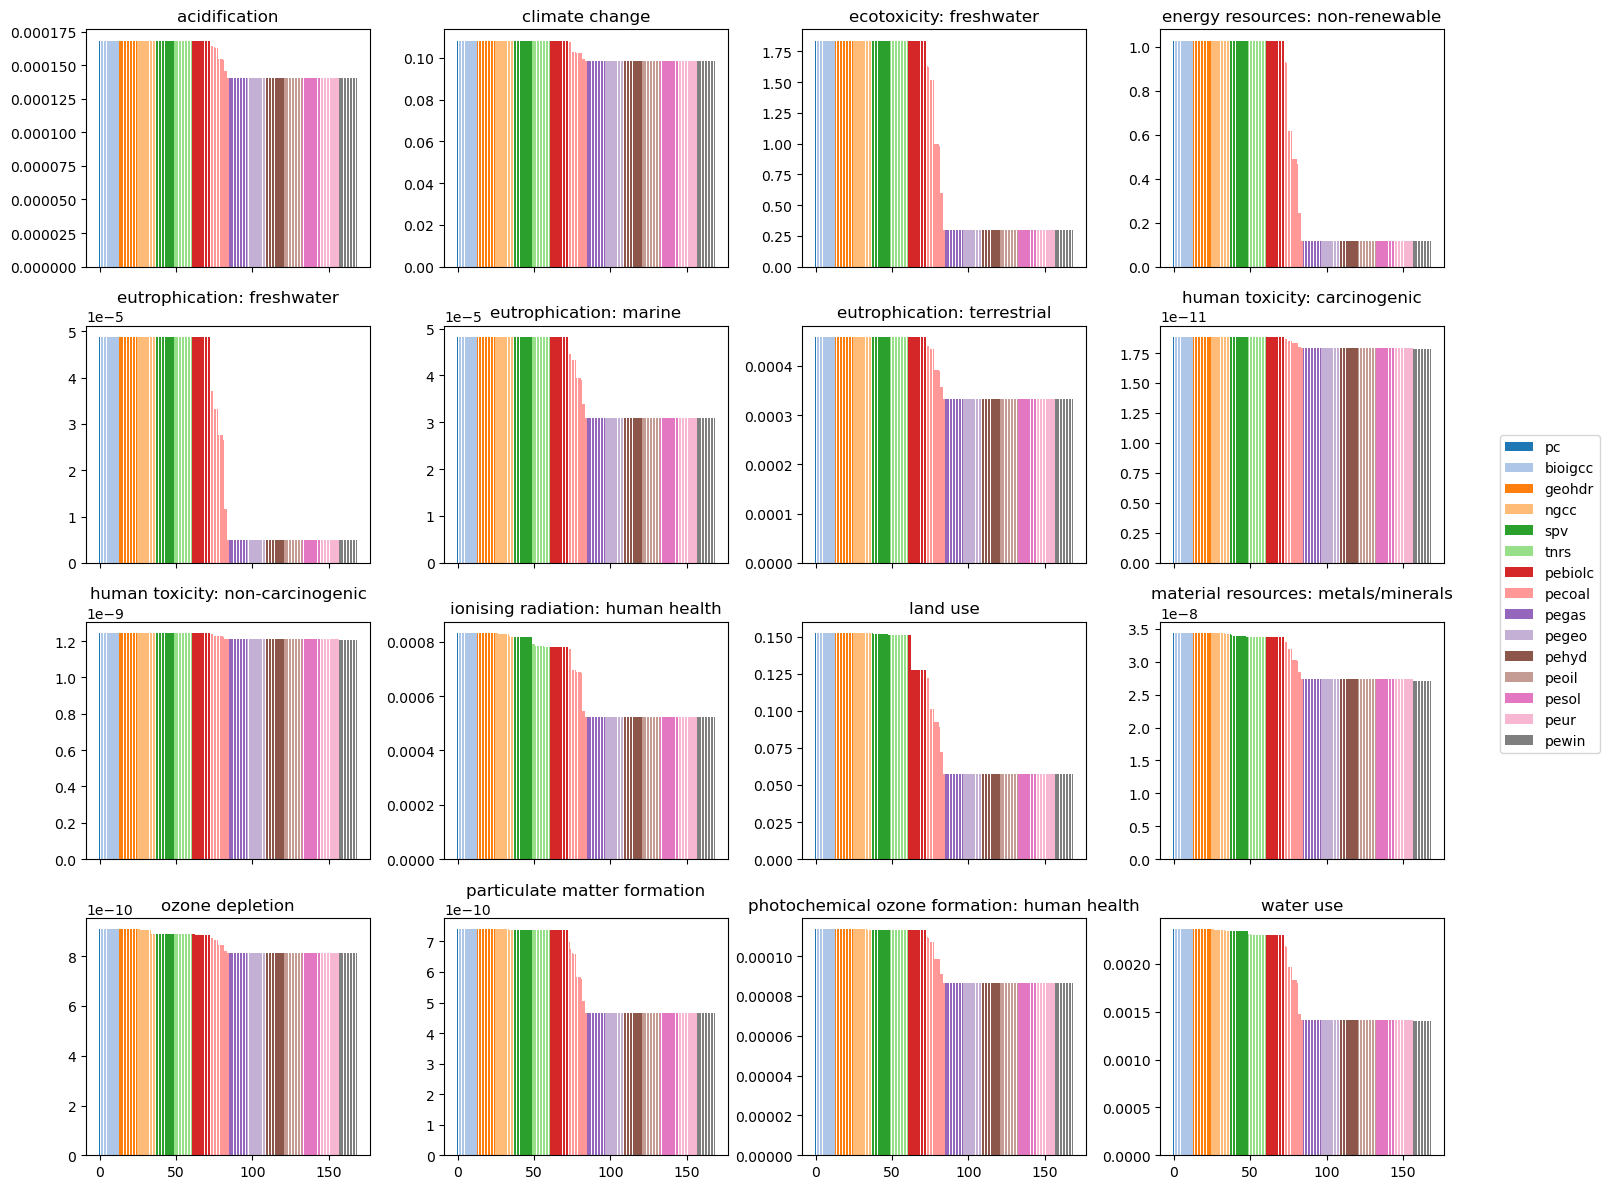

In [55]:
fig, axs = plt.subplots(
    nrows=4, ncols=4, 
    constrained_layout=True, sharex=True, sharey=False,
    figsize=(16, 12)
)

legend_elements = []
for label, color in zip(["pc"]+other_techs, cmap.colors[:len(techs)]):
    p = Patch(facecolor=color, label=label)
    legend_elements.append(p)

for ax, mp, y in zip(axs.flat, midpoints, impacts.T):
    ax.set_title(mp)
    ax.bar(np.arange(y.size), y, color=colors)

fig.legend(handles=legend_elements, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.9)